<a href="https://colab.research.google.com/github/shub-codes/HateSpeechDetection/blob/main/Hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/thedevastator/hate-speech-and-offensive-language-detection")

<h1> 1) importing libraries</h1>
<ol>
<li> <h3>  pandas - analyse, clean,explore and manipulate the dataset .<br>
<li>  <h3> re or regex - A RegEx, or Regular Expression, is a sequence of characters that forms a search pattern. RegEx can be used to check if a string contains the specified search pattern.<br>
<li> <h3> nltk- natural language transformer kit.<br>


In [ ]:
import pandas as pd #to read and write csv files
import numpy as np
import nltk
nltk.download('stopwords') # natural language toolkit
import re #regular expressions
from nltk.corpus import stopwords # to remove words like a, the,is etc. such words contribute almost nothing
from nltk.stem import WordNetLemmatizer # to impplement lemmitisation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import backend as K


<h1> 2) Importing and reading data

In [11]:
df=pd.read_csv("/content/hate-speech-and-offensive-language-detection/train.csv")
# print(df.head(5))
print(f"df has {df.shape[0]}  rows and {df.shape[1]} cols")
for head in df.columns[:-1]:
  print(f"{head}")
  print(f"null values = {df[head].isnull().sum()}")
  print(f"description of {head} is as follows {df[head].describe()}")

df has 24783  rows and 6 cols
count
null values = 0
description of count is as follows count    24783.000000
mean         3.243473
std          0.883060
min          3.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          9.000000
Name: count, dtype: float64
hate_speech_count
null values = 0
description of hate_speech_count is as follows count    24783.000000
mean         0.280515
std          0.631851
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: hate_speech_count, dtype: float64
offensive_language_count
null values = 0
description of offensive_language_count is as follows count    24783.000000
mean         2.413711
std          1.399459
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          9.000000
Name: offensive_language_count, dtype: float64
neither_count
null values = 0
description of neither_count is as follows count    24783.000000

<h2> plotting dataset</h2>

                          hate_speech_count  offensive_language_count  \
hate_speech_count                  1.000000                 -0.261808   
offensive_language_count          -0.261808                  1.000000   
neither_count                     -0.157599                 -0.684406   
class                             -0.515732                 -0.410440   

                          neither_count     class  
hate_speech_count             -0.157599 -0.515732  
offensive_language_count      -0.684406 -0.410440  
neither_count                  1.000000  0.800687  
class                          0.800687  1.000000  


<Axes: >

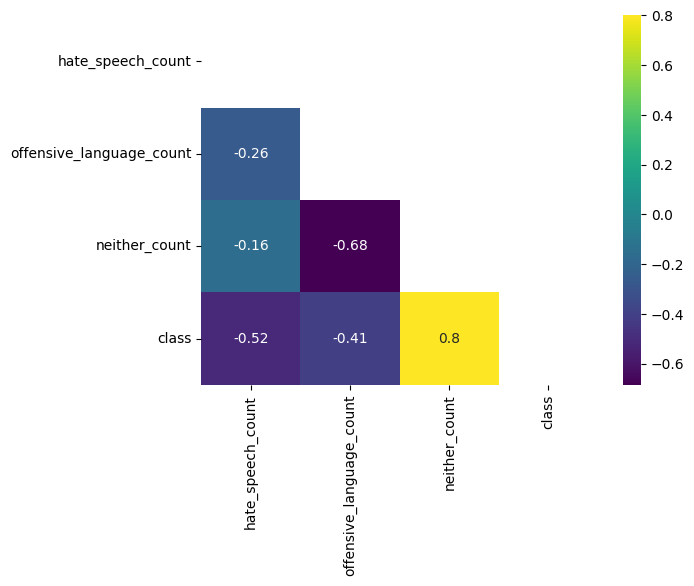

In [19]:
import seaborn as sns
df_corr=df.drop(columns=[df.columns[-1],df.columns[0]])
df_corr=df_corr.corr()
mask=np.triu(np.ones_like(df_corr))
print(df_corr)
sns.heatmap(df_corr,annot=True,mask=mask,cmap="viridis")


<h1> 3) CLEANING THE DATA USING REGULAR EXPRESSIONS </h1>
<h3> implement lemmitisation function after initial model training. compare the results with and without lemmitisation. compare runtime, accuracy and f1 score

In [ ]:
stopWords= set(stopwords.words('english'))
stopWords.add('RT') # to add the RT which means retweet
#remove html entity
def remove_entity(raw_text):
  text_regex= r"&(#\d+|#x[a-fA-F0-9]+|[a-zA-Z]+);"
  updated_text=re.sub(text_regex,"",raw_text)
  return updated_text
# removes user tags
def remove_user_tags(raw_text):
  user_regex=r"@\w+"
  updated_text=re.sub(user_regex,"",raw_text)
  return updated_text
# removes urls
def remove_urls(raw_text):
  url_regex=r"https?://\S+|www\.\S+"
  updated_text=re.sub(url_regex,"",raw_text,flags=re.IGNORECASE)
  return updated_text
# to remove unnecessary markings
def remove_noise(raw_text):
  noise_regex=r"['\"!`]|\.{2,}"
  updated_text=re.sub(noise_regex,"",raw_text)
  return updated_text
# to tokenise the string and remove stopwords
def remove_stopwords(raw_text):
  tokenize= nltk.word_tokenize(raw_text)
  updated_text=[word for word in tokenize if word not in stopWords]
  return " ".join(updated_text)
# implement this lemmatizer ony after initial model training. After implementing, check for any changes in results
# def lemmitize(raw_text):
#   lemmatizer=WordNetLemmatizer()
#   tokenise=nltk.tokenize.word_tokenize(raw_text)
#   lemminised_words=[lemmatizer.lemmatize(word) for word in tokenise]
#   return " ".join(lemminised_words)
# calling all the above functions
def preprocess(raw_text):
  updated=[]
  updated=[remove_entity(text) for text in raw_text]
  updated=[remove_user_tags(text) for text in updated]
  updated=[remove_urls(text) for text in updated]
  updated=[remove_noise(text) for text in updated]
  updated=[remove_stopwords(text) for text in updated]
  # updated=[lemmitize(text) for text in updated ]
  return updated
updated_tweet=preprocess(tweet)

<h2> Explaination of regex given above</h2>
<ul>
<li> <h3> HTML func regex = r"&(#\d+|#x[a-fA-F0-9]+|[a-zA-Z]+)
  <ul> <li>r stands to tell that the text is raw
      <li>  #\d tells for numeric references eg &#12345
      <li> #x[a-fA-F0-9] tells for hexadecimal numeric references
      <li> [a-zA-Z] mathces named entities &amp, &lt
  </ul>
<li><h3> user tags func = r"@\w+"
  <ul> <li> \w stands for  all alphanumeric letters and _
        <li> example "Hey @john_doe, check this out! Also, @alice123 and @user.test are here." changes to "Hey user, check this out! Also, user and user are here."
  </ul>
<li><h3> url func = r"https?://\S+|www\.\S+"
  <ul> <li> https? means the s in last is optional. hence it mathces to both http and https.
      <li> \S+ matches any additional string
      <li> www\.\S+ matches for all url in for www.dsfdjskn.com
      <li> flag=re.IGNORECASE means it matches irrespective of case of letters
  </ul>
<li> <h3> remove noise func
  <ul> <li> removes ", ', !' or two and more dots
  </ul>


<h1> 4) splitting the data into training and testing

In [ ]:
x_train,x_test,y_train,y_test=train_test_split()